In [31]:
# %load_ext autoreload
# %autoreload 2

import os
import torch
from skimage import io, measure
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave

import warnings
warnings.filterwarnings('ignore')

from tifffile import imread




if not torch.cuda.is_available():
    raise ValueError("GPU not found, code will run on CPU and can be extremely slow!")
else:
    device = torch.device("cuda:0")

import time
from glob import glob
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
import torch.optim as optim
import torch.utils.data as dt


import os
os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap')
from GAP_UNET_ResBlockv2 import UN
from BinomDatasetv3 import BinomDataset
from inference import sample_image
from tasks import inpainting

In [32]:
name = 'm40tom5-256x256-v2'
CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/'
# mask = torch.from_numpy(masks.generate_mask())
# torch.from_numpy()
model = UN(channels = 1, levels=10, depth=6, 
           start_filts=28, up_mode = 'transpose').to(device)
model = UN.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

In [33]:
dataTest = imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testData.tif')[:1]     # to speed things up, we are only doing the first image
dataTestGT =imread('/mnt/c/Users/ankit/Desktop/Msc AIML/Data/convallaria/testDataGT.tif')[:1]
dataTest.shape

(1, 512, 512)

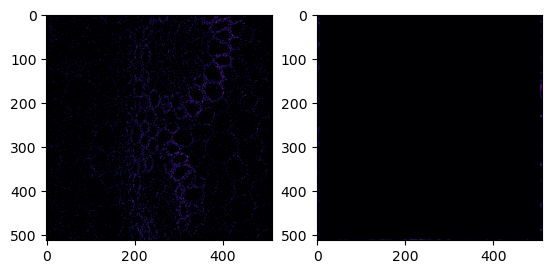

In [192]:
masks = inpainting(imgsize = 512, masksize = 512)
mask = masks.generate_mask().numpy()
test = dataTest * mask
cond_test = dataTestGT * (1 - mask)

plt.subplot(1, 2, 1)
plt.imshow(test[0], 'inferno')
plt.subplot(1, 2, 2)
plt.imshow(cond_test[0], 'inferno')

320.0 0.0 4.923943 73.0 0.0
(512, 512)


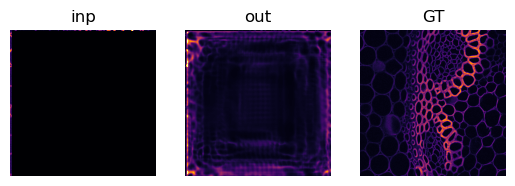

In [193]:
outputs = []
# masks = inpainting(imgsize = 512, masksize = 128)
# mask = masks.generate_mask()
# add = dataTestGT * (1 - mask)
for inp, gt in zip(test, cond_test):  
    inpT = torch.from_numpy((inp).astype(np.float32)).to(device) 
    cond_inpT = torch.from_numpy(gt).to(device)
    # inpT = torch.zeros_like(inpT).to(device)
    inpT = torch.cat([cond_inpT[None], inpT[None]], dim = 0).to(device)
  
    out = torch.exp(model(inpT[None]).detach().cpu())
    out = inp.sum() * out / out.sum() ## multiply noisy image with probability distribution of clean image?
    outputs.append(out.numpy()[0,0])
    
    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))
    print(inp.shape)
    inp = dataTest[0]/dataTest[0].mean() * mask
    out = out/out.mean()
    gt = dataTestGT[0]/dataTestGT[0].mean() * (1 - mask)
    add = add/add.mean()
    vmax = np.percentile(gt,99.9)
    out = gt[None, None] + (out.numpy() * mask[None])
    # plt.figure(figsize=(10,10))
    # plt.subplot(1, 4, 2)
    # plt.imshow(inpT[1].cpu(),vmin = 0, vmax = vmax, cmap = "inferno")
    # plt.title('inp')
    # plt.axis('off')
    # plt.show()
    vmax = np.percentile(out,99.9)

    plt.subplot(1, 3, 2)
    # plt.figure(figsize=(7,7))
    plt.imshow(out[0, 0, 0][:500,:500],vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('out')
    plt.axis('off')

    vmax = np.percentile(gt,99.9)
    # plt.show()
    plt.subplot(1, 3, 1)
    # plt.figure(figsize=(7,7))
    plt.imshow(gt[0][:500,:500],vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('inp')
    plt.axis('off')
    vmax = np.percentile(gt,99.9)
    plt.subplot(1, 3, 3)
    # plt.figure(figsize=(7,7))
    plt.imshow(dataTestGT[0], cmap = "inferno")
    plt.title('GT')
    plt.axis('off')

    plt.show()


In [36]:
dataTestGT.shape, mask.shape

((1, 512, 512), (1, 512, 512))

332 0 44.3373404001294 272.0 17.0


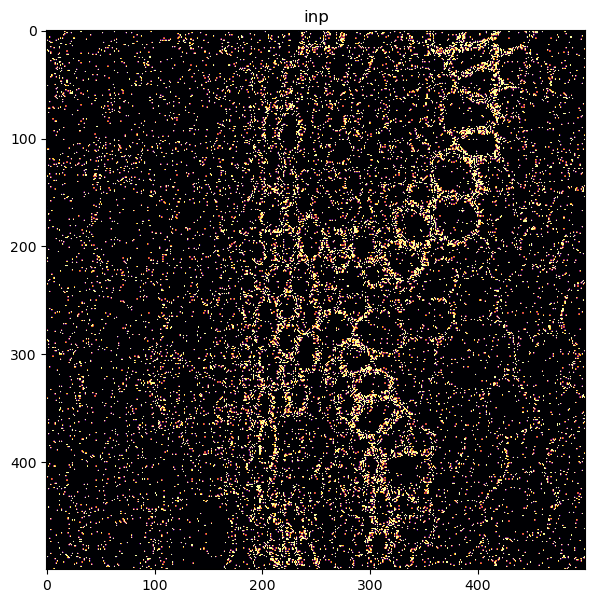

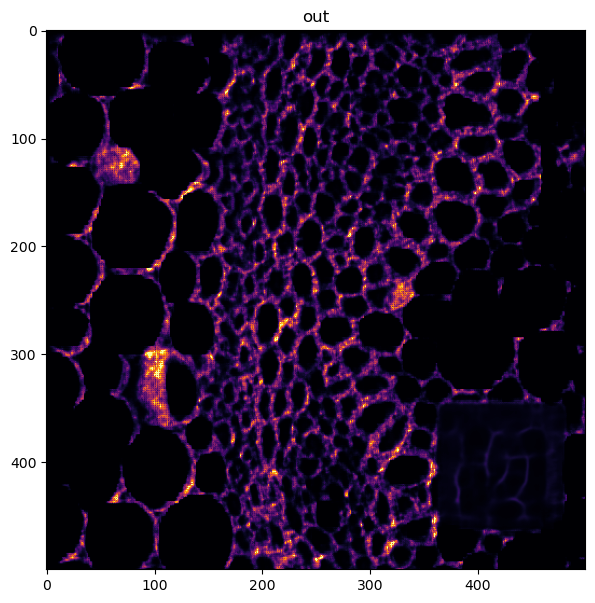

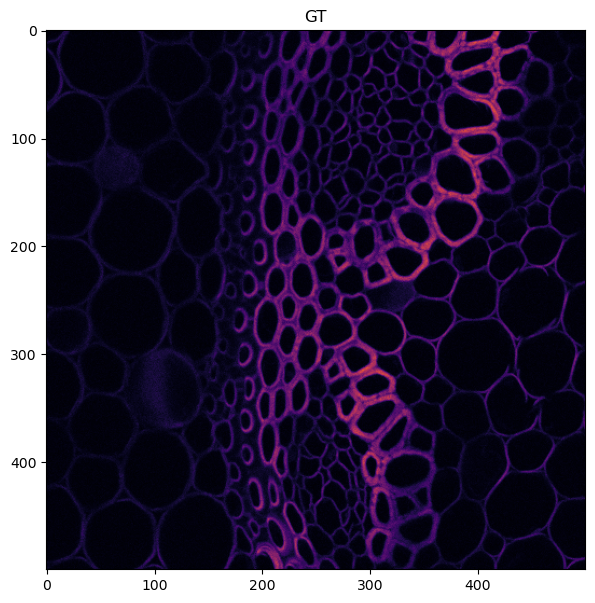

In [ ]:
outputs = []
for inp, gt in zip(dataTest, dataTestGT):  
    # print(inp.shape)
    # print(gt.shape)
    inpT = torch.from_numpy(inp.astype(np.float32))[None].to(device)
    inpT = torch.cat([torch.from_numpy(cond).to(device), inpT], dim = 0).to(device)
    # model(torch.cat([torch.zeros_like( torch.from_numpy(dataTest)), torch.from_numpy(dataTest)], dim = 0)[None])
    # We have to apply softmax over pixels
    out = torch.exp(model(inpT[None]).detach().cpu())
    out = inp.sum() * out / out.sum() ## multiply noisy image with probability distribution of clean image?
    outputs.append(out.numpy()[0,0])
    
    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))
    
    inp = inp/inp.mean()
    out = out/out.mean()
    gt = gt/gt.mean()
    vmax = np.percentile(gt,99.9)
    
    plt.figure(figsize=(7,7))
    plt.imshow(inp[:500,:500],vmin = 0, vmax = vmax, cmap = "inferno")
    plt.title('inp')
    plt.show()
    
    vmax = np.percentile(out,99.9)

    plt.figure(figsize=(7,7))
    plt.imshow(out[0,0][:500,:500],vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('out')
    plt.show()
    
    plt.figure(figsize=(7,7))
    plt.imshow(gt[:500,:500],vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('GT')
    plt.show()


In [136]:
import matplotlib.image as mpimg
import time
import numpy as np
from inference import sample_image

# We are starting with an image containing zeros,
# i.e., sampling from scratch

# we just have 1 channel
channels = 1
# we can sample multiple images at the same time in a batch
batch_size = 1
# for best results this should correspond to training pach size
pixels_x = 512
pixels_y = 512
# cond_test = cond_test
# zero_test = torch.zeros_like(cond_test)
# inp_img =  torch.cat((cond_test, zero_test), dim = 1).to(device)
cond = torch.from_numpy(cond_test[None]).to(device)
inp_img =  torch.zeros(batch_size ,channels, pixels_y, pixels_x).to(device)
print(inp_img.shape)
print(cond.shape)

inp_img = torch.cat((cond, inp_img), dim = 1).to(device)
print(inp_img.shape)
for i in range(1):
    

    startTime = time.time()
    
    # sampling the image(s)
    denoised, photons, stack, iterations = sample_image(inp_img,
                                                        model, 
                                                        beta = 0.05,
                                                        save_every_n = 10,
                                                        max_psnr = -3)

    
    # In case we do multiple images in a batch, we show all of them.
    for j in range(denoised.shape[0]):
#         print(iterations)

            print(denoised.shape)
            plt.figure(figsize = (5,5))
            plt.imshow(denoised[j,0], cmap='inferno', vmin = 0,
                       vmax = np.percentile(denoised[j],99.99))
            plt.title('Denoisied')
            plt.show()
            
            plt.figure(figsize = (5,5))
            plt.imshow(photons[j,0], cmap='inferno', vmin = 0,
                       vmax = np.percentile(photons[j],99.99))
            plt.title('Photon counts')
            plt.show()
            
            
    
    print('_______________________________________', iterations)
    
    
    
    
    endTime = time.time()
    elapsedTime = endTime - startTime
    print ('time (s):', elapsedTime, 'time per image (s)', elapsedTime/denoised.shape[0])
   

torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])
torch.Size([1, 2, 512, 512])


TypeError: 'NoneType' object is not subscriptable

0


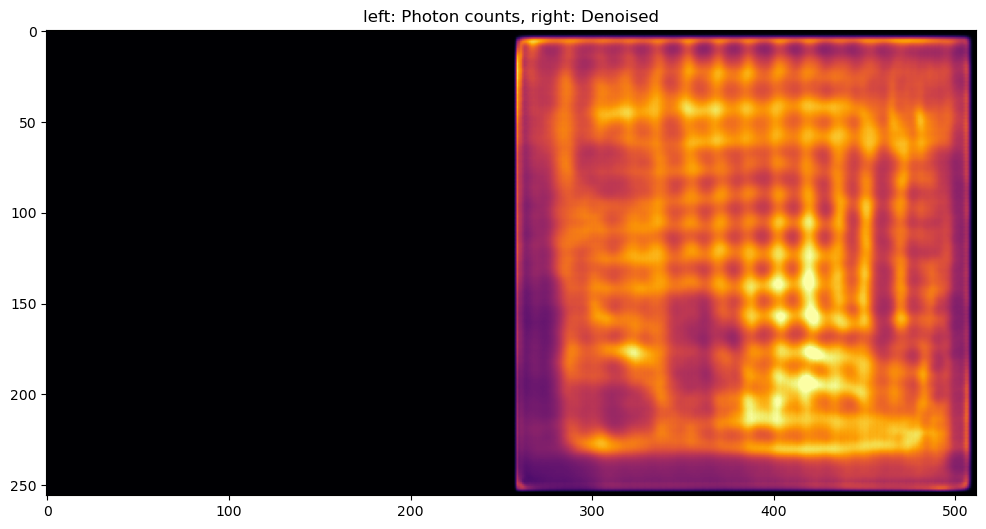

1


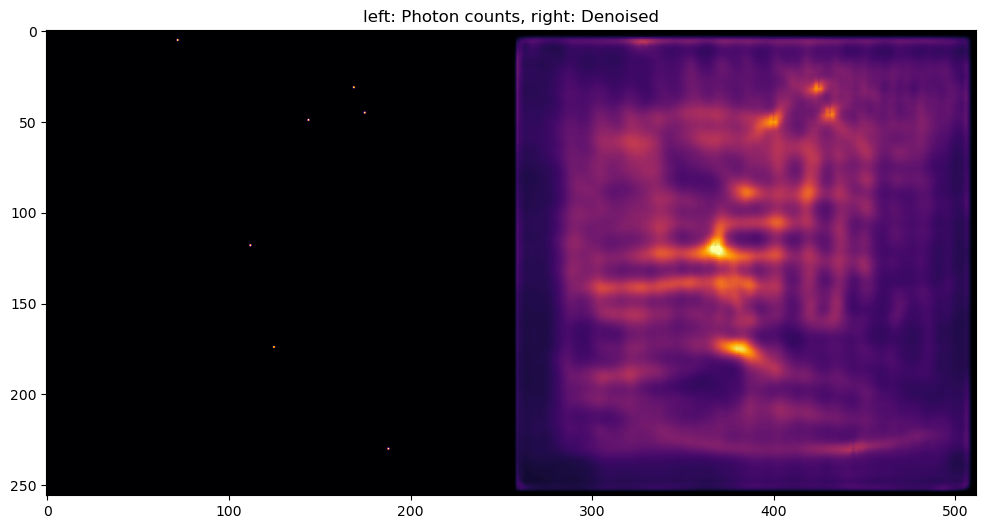

2


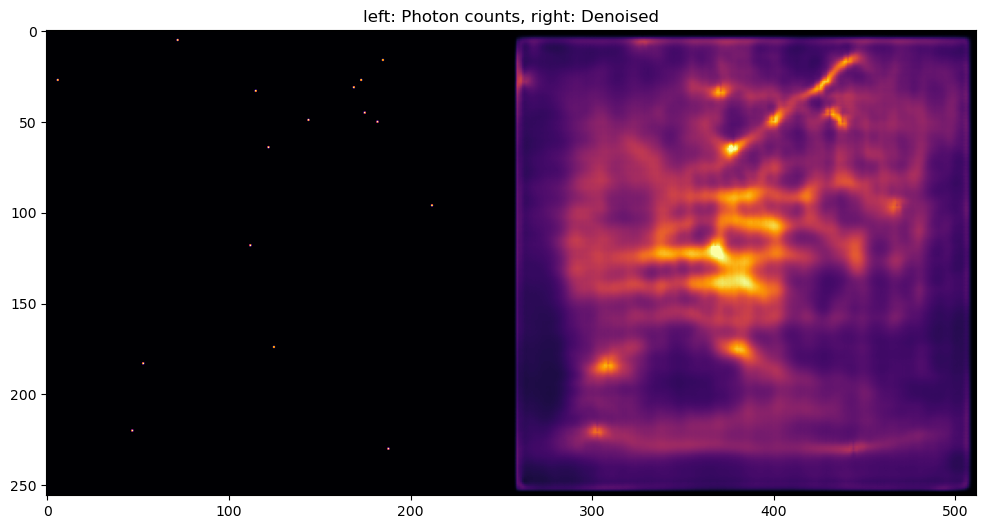

3


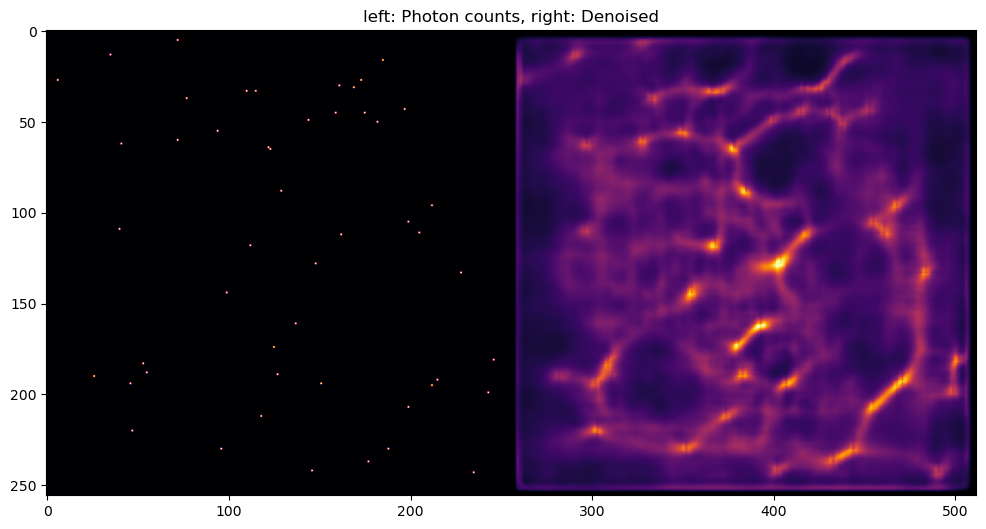

4


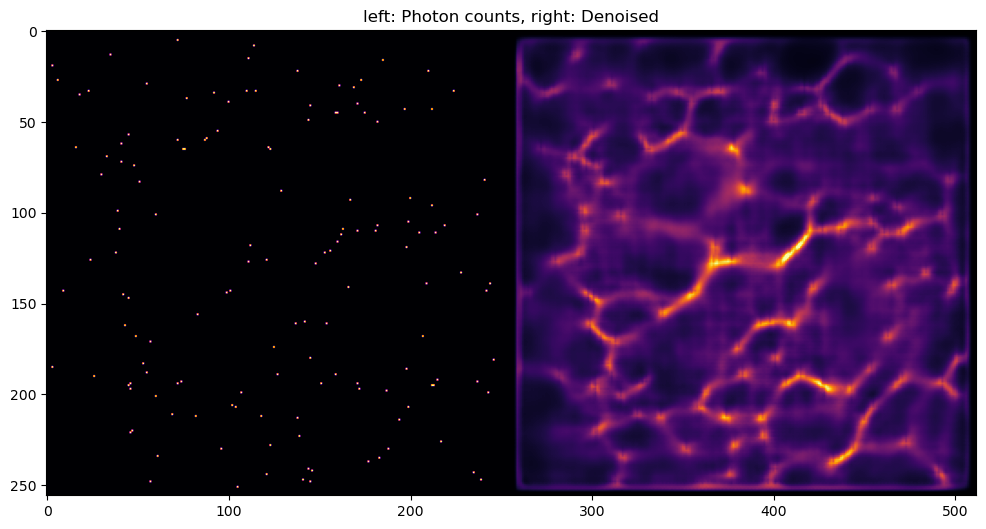

5


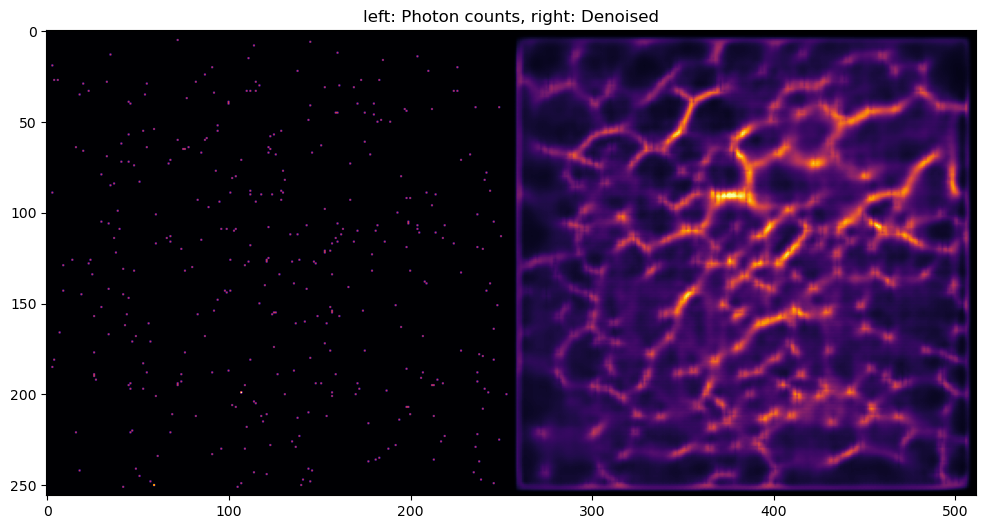

6


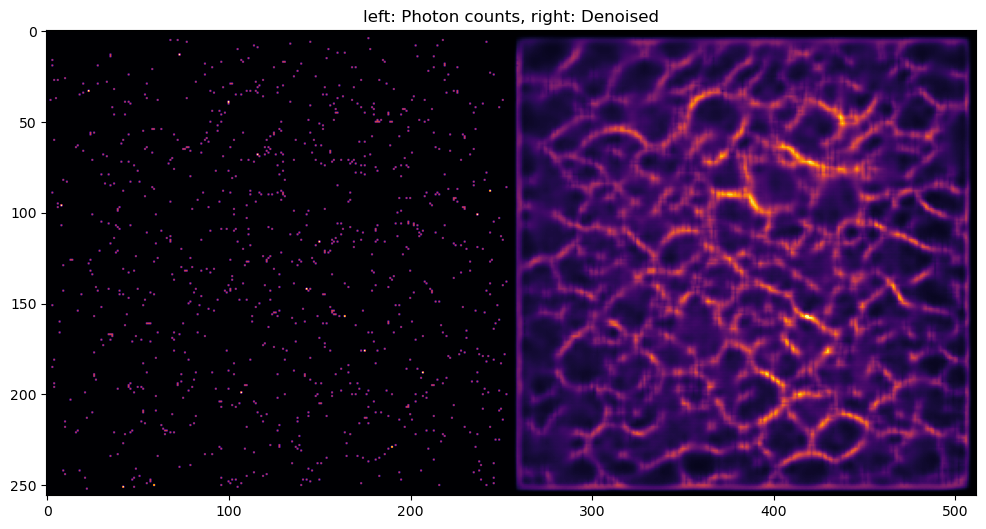

7


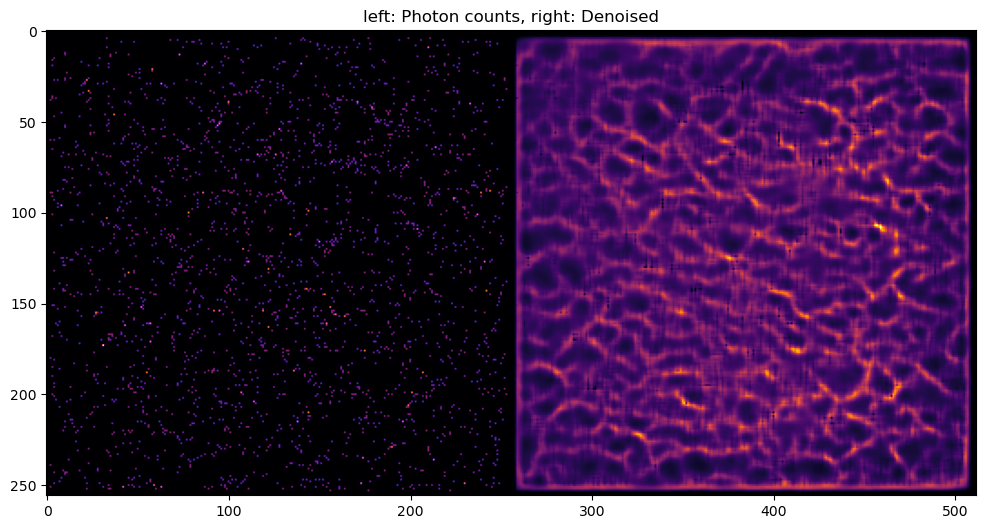

8


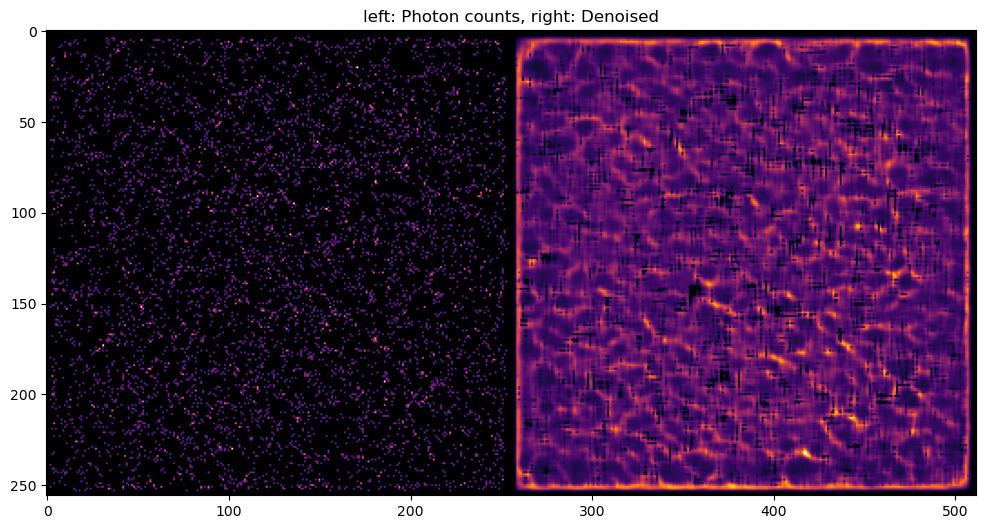

9


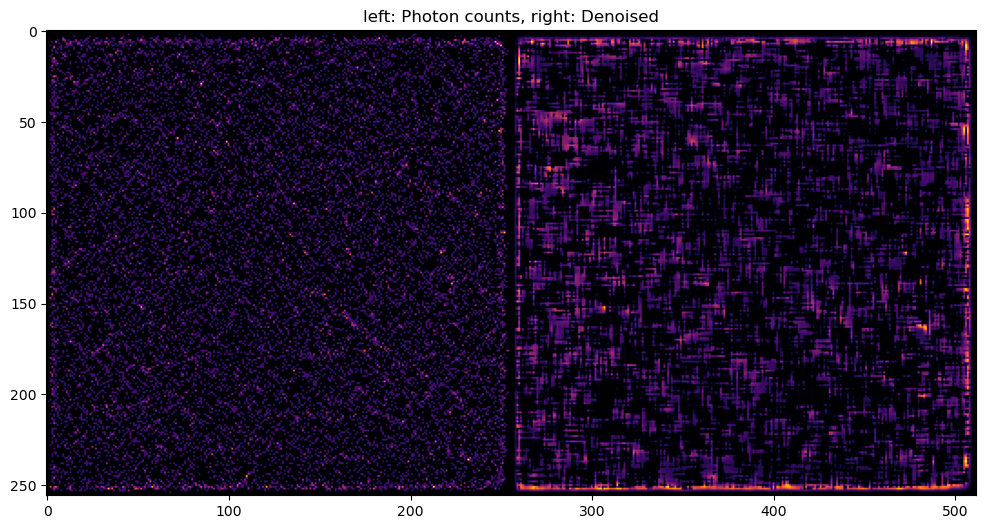

In [129]:
stack[0].shape
for i in range(len(stack)):
    im = stack[i]
    print(i)
    plt.figure(figsize = (12,12))
    plt.imshow(im,cmap ='inferno', vmax = 0.9)
    plt.title('left: Photon counts, right: Denoised')
    plt.show()